# INST728E - Module 5. Temporal Analysis

In this section, we will cover a few simple analysis techniques to garner some small insights rapidly.

- Time parsing
- Frequency Graph
- Keyword Frequency

### Zooming in on an event

Then we'll look at relevant tweets and answer some questions:

- Top users
- Top hash tags
- Top URLs
- Top images
- Most retweeted tweet

In [1]:
%matplotlib inline

import datetime
import json
import gzip
import glob
import os
import string

import numpy as np

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

## Defining An Event

The following notebook walks us through a number of capabilities or common pieces of functionality one may want when analyzing Twitter following a crisis.
We will start by defining information for an event for which we have data.

You can replace this dictionary or add to it with an event of your own! In fact, you'll need to do so for this module's homework.

In [2]:
crisisInfo = {
    "brussels": {
        "name": "Brussels Transit Attacks",
        "time": 1458629880, # Timestamp in seconds since 1/1/1970, UTC
                            # 22 March 2016, 6:58 UTC to 08:11 UTC
        "directory": "brussels",    # Where do we find the relevant files
        "keywords": [    # How can we describe this event?
            "brussels", "bomb", "belgium", "explosion"
        ],
        "box": {    # Where did this event occur?
            "lowerLeftLon": 2.54563,
            "lowerLeftLat": 49.496899,
            "upperRightLon": 6.40791,
            "upperRightLat": 51.5050810,
        }
    }, 
    "boston" : {
        
    }
}

<hr>

## Reading Tweets

The first thing we do is read in tweets from a directory of compressed files. Our collection of compressed tweets is in the 00_data directory, so we'll use pattern matching (called "globbing") to find all the tweet files in the given directory.

Then, for each file, we'll open it, read each line (which is a tweet in JSON form), and build an object out of it. As part of this process, we will extract each tweet's post time and create a map from minute timestamps to the tweets posted during that minute.

In [3]:
selectedCrisis = "brussels"

# Determine host-specific location of data
tweetDirectory = crisisInfo[selectedCrisis]["directory"]
tweetGlobPath = os.path.sep + os.path.join("Users", "cbuntain", "tmp", "data",
                             "00_data", tweetDirectory, "statuses.log.*.gz")

print ("Reading files from:", tweetGlobPath)

# Dictionary for mapping dates to data
frequencyMap = {}

# Twitter's time format, for parsing the created_at date
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"

for tweetFilePath in glob.glob(tweetGlobPath):
    print ("Reading File:", tweetFilePath)

    for line in gzip.open(tweetFilePath, 'rb'):

        # Convert from bytes to UTF8 string
        decoded_line = line.decode("utf8")
        
        # Try to read tweet JSON into object
        tweetObj = None
        try:
            tweetObj = json.loads(decoded_line)
        except json.JSONDecodeError as jde:
            print("JSON Decode Error:", decoded_line)
            continue

        # Deleted status messages and protected status must be skipped
        if ( "delete" in tweetObj.keys() or "status_withheld" in tweetObj.keys() ):
            continue

        # Try to extract the time of the tweet
        try:
            currentTime = datetime.datetime.strptime(tweetObj['created_at'], timeFormat)
        except:
            print("Error parsing time on line:", decoded_line)
            raise

        # Flatten this tweet's time
        currentTime = currentTime.replace(second=0)

        # If our frequency map already has this time, use it, otherwise add
        extended_list = frequencyMap.get(currentTime, [])
        extended_list.append(tweetObj)
        frequencyMap[currentTime] = extended_list

Reading files from: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.*.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-11-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-08-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-05-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-07-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-09-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-10-sampled.gz
Reading File: /Users/cbuntain/tmp/data/00_data/brussels/statuses.log.2016-03-22-06-sampled.gz


In [4]:
# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

# We want to look at per-minute data, so we fill in any missing minutes
timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
while ( thisTime <= lastTime ):

    frequencyMap[thisTime] = frequencyMap.get(thisTime, [])
        
    thisTime = thisTime + timeIntervalStep

# Count the number of minutes
print ("Start Time:", firstTime)
print ("Stop Time:", lastTime)
print ("Processed Times:", len(frequencyMap))
    
# Count all the tweets per minute
print ("Processed Tweet Count:", np.sum([len(x) for x in frequencyMap.values()]))

Start Time: 2016-03-22 04:59:00
Stop Time: 2016-03-22 11:59:00
Processed Times: 421
Processed Tweet Count: 227667


### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per minute.

Crisis Time: 2016-03-22 06:58:00
Time Frame: 2016-03-22 04:59:00 2016-03-22 11:59:00


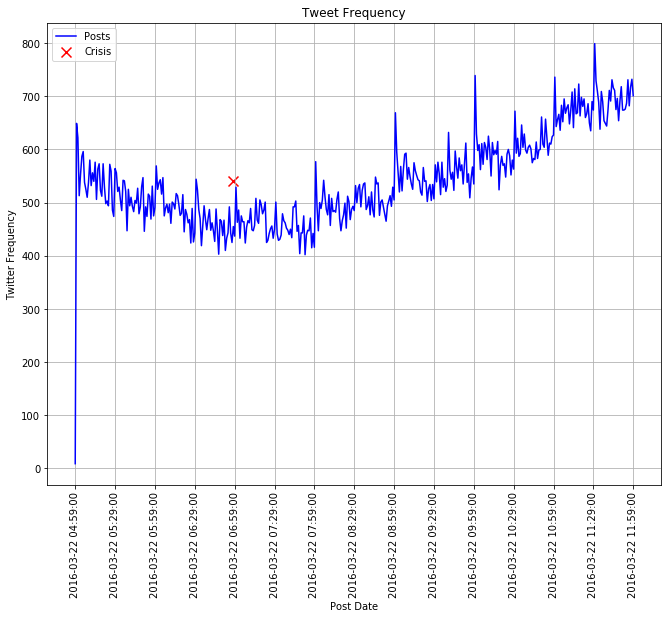

In [5]:
# Get data about our crisis
crisisMoment = crisisInfo[selectedCrisis]["time"] # When did it occur by epoch time
crisisTime = datetime.datetime.utcfromtimestamp(crisisMoment) # Convert to datetime
crisisTime = crisisTime.replace(second=0) # Flatten to a specific minute

# Print converted time
print ("Crisis Time:", crisisTime)

# Create a new figure in which to plot minute-by-minute tweet count
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [len(frequencyMap[x]) for x in sortedTimes]

# We'll have ticks every few minutes (more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 30)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), postFreqList, color="blue", label="Posts")

# Get the index for when our crisis occurred
crisisXCoord = sortedTimes.index(crisisTime)
ax.scatter([crisisXCoord], [np.mean(postFreqList)], c="r", marker="x", s=100, label="Crisis")

ax.grid(b=True, which=u'major')
ax.legend()

ax.set_xlabel("Post Date")
ax.set_ylabel("Twitter Frequency")

plt.show()

## Zooming in on an Event


Let's zoom in on who was tweeting about this event as well and what they are saying:

- Top users
- Top hash tags
- Top URLs
- Most retweeted tweet

For each question, let's look between generally popular and relevant tweets. "Relevance" comes in several forms though: temporal (posted around the same time), textual (mentions the event), social (mentions someone who experienced the event), or spatial (happened in/mentions the same place).

We'll first look at tweets that happened right after the event.

In [6]:
# List of relevant tweet times
after_event_times = []

relevant_time_span = 60 # Let's look at the first few minutes after the event

current_time_span = 0
for current_time in sortedTimes:
    
    # Is this time after when the crisis occurred?
    if ( current_time >= crisisTime ):
        after_event_times.append(current_time)
        current_time_span += 1
        
    # Only look at the first few time frames
    if ( current_time_span > relevant_time_span ):
        break

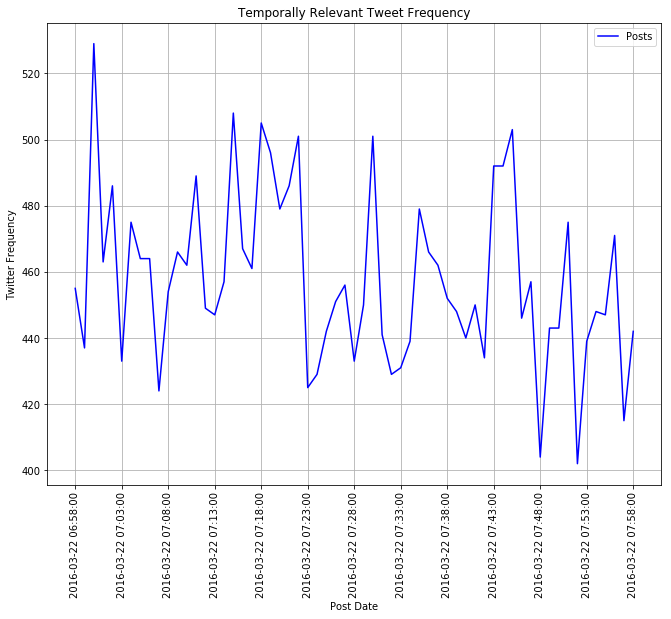

In [7]:
# Create a new figure in which to plot minute-by-minute tweet count
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

plt.title("Temporally Relevant Tweet Frequency")

# Get a count of tweets per minute
postFreqList = [len(frequencyMap[x]) for x in after_event_times]

# We'll have ticks every few minutes (more clutters the graph)
smallerXTicks = range(0, len(after_event_times), 5)
plt.xticks(smallerXTicks, [after_event_times[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(after_event_times)), postFreqList, color="blue", label="Posts")

ax.grid(b=True, which=u'major')
ax.legend()

ax.set_xlabel("Post Date")
ax.set_ylabel("Twitter Frequency")

plt.show()

### What were people saying during this time?

In [8]:
# Find tweets in this time frame
temporally_relevant_tweets = [tweet 
                              for rel_time in after_event_times    # for each time frame after the event
                              for tweet in frequencyMap[rel_time]] # Pull tweets in that time frame

print("Tweet Count:", len(temporally_relevant_tweets))

Tweet Count: 27934


In [9]:
tokenizer = TweetTokenizer()
stops = stopwords.words("english")

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it tokenizes the tweet text
tokens = [
        token.lower() 
         for tweet in temporally_relevant_tweets 
             for token in tokenizer.tokenize(tweet["text"])
        ]
tokens = list(filter(lambda x: x not in stops and len(x) > 3, tokens))

print("Total Token Count:", len(tokens))
print("Unique Token Count:", len(set(tokens)))

tokens_freq = nltk.FreqDist(tokens)

print("\nFrequent Tokens:")
for token, count in tokens_freq.most_common(20):
    print(token, count)

Total Token Count: 171236
Unique Token Count: 101020

Frequent Tokens:
الله 466
like 349
love 342
https 336
اللهم 249
airport 244
weather 236
people 229
2016 206
good 191
time 189
#ebholytuesday 184
explosions 174
know 165
life 161
para 152
video 151
yang 149
https://… 147
happy 145


In [10]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the hashtags list
htags = [
        hashtag["text"].lower() 
         for tweet in temporally_relevant_tweets 
             for hashtag in tweet["entities"]["hashtags"]
        ]

print("Total Hashtag Count:", len(htags))
print("Unique Hashtag Count:", len(set(htags)))

htags_freq = nltk.FreqDist(htags)

print("\nFrequent Hashtags:")
for tag, count in htags_freq.most_common(20):
    print(tag, count)

Total Hashtag Count: 10697
Unique Hashtag Count: 6323

Frequent Hashtags:
ebholytuesday 200
iheartawards 101
msgpureproducts 84
brussels 83
zaventem 80
pimpmysummerball 63
bestfanarmy 61
gameinsight 51
android 45
androidgames 39
purposetourlosangeles 36
bruxelles 35
breaking 34
directioners 33
nowplaying 30
flight_log 30
rtした人全員フォローする 29
brusselsairport 29
bestcover 27
merapopormariobau 27


In [11]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the author list
authors = [tweet["user"]["screen_name"].lower() for tweet in temporally_relevant_tweets]

print("Total Author Count:", len(authors))
print("Unique Author Count:", len(set(authors)))

author_freq = nltk.FreqDist(authors)

print("\nActive Users:")
for author, count in author_freq.most_common(20):
    print(author, count)

Total Author Count: 27934
Unique Author Count: 27327

Active Users:
toshito13_rugby 5
fmkall7 4
shinobininja 4
lisatlevy1 4
freshxhyunjoo 3
travelonesia 3
ms_tw_ 3
rodri_julian_ 3
canada_d_deals 3
sanand1979 3
wael_m305 3
n2takanotume 3
agrawalsanjay77 3
xtronnorpride 3
lucenateray 3
nimfasapa1 3
remigiusunachu2 3
amine0571 3
roso1954 3
_nonnon_ 3


In [12]:
# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the URL list
urls = [
        url["expanded_url"]
         for tweet in temporally_relevant_tweets 
             for url in tweet["entities"]["urls"]
        ]

print("Total URL Count:", len(urls))
print("Unique URL Count:", len(set(urls)))

urls_freq = nltk.FreqDist(urls)

print("\nCommon URLs:")
for url, count in urls_freq.most_common(20):
    print(url, count)

Total URL Count: 8211
Unique URL Count: 6905

Common URLs:
http://du3a.org 316
http://zad-muslim.com 50
http://ketabiapp.com/ 42
http://gigam.es/imtw_Tribez 37
http://fllwrs.com 30
http://d3waapp.org/ 27
http://rb2.in/bhIr 26
http://www.tuitutil.net 22
http://Gharedly.Net 21
http://bnent.jp/optw/ 20
http://wthker.com/ 20
https://twibble.io 16
http://bnent.jp/optc-den2e/ 15
http://ghared.com 13
http://sk88go.blogspot.kr 12
http://7asnat.com/ 12
https://cards.twitter.com/cards/18ce549yohj/1k5ya 11
http://bit.ly/1o0QMDs 11
https://amp.twimg.com/v/2665812c-6c0b-4b24-9909-61329350b370 11
https://youtu.be/7f_QpWndQws 10


### Most retweeted tweet AFTER event

In [13]:
# Find retweets
retweets = list(filter(lambda x: "retweeted_status" in x, temporally_relevant_tweets))
print("Retweet Count:", len(retweets))

# But we also want to filter out retweets whose original tweet
#  was posted BEFORE our event
retweets = list(filter(
    lambda tweet: crisisTime <= datetime.datetime.strptime(tweet["retweeted_status"]["created_at"], timeFormat),
    retweets
))
print("Recent Retweet Count:", len(retweets))

# For each retweet, get its pair
rt_pairs = [(tweet["retweeted_status"]["id"], tweet["retweeted_status"]["retweet_count"]) 
          for tweet in retweets]

# Get the unique tweet IDs
uniq_ids = set([x[0] for x in rt_pairs])

# Map retweet IDs to their counts
rt_map = {}
for local_id in uniq_ids:
    max_rt_count = max([x[1] for x in filter(lambda x: x[0] == local_id, rt_pairs)])
    rt_map[local_id] = max_rt_count
    
# Sort the retweets by count
top_5_rts = sorted(rt_map, key=rt_map.get, reverse=True)[:5]

# For each of the top 5, print them
for rt in top_5_rts:
    
    tweet = list(filter(lambda x: x["retweeted_status"]["id"] == rt, retweets))[0]
    
    print(rt, rt_map[rt])
    print("\tTweet:", tweet["text"])
    print()

Retweet Count: 10477
Recent Retweet Count: 3297
712173394049896448 9721
	Tweet: RT @justinbieber: Shout out to one of my inspirations @kanyewest for coming to the show tonight. Had to go big. #PurposeTourLosAngeles nigh…

712175074460114944 8939
	Tweet: RT @BTS_jp_official: [BTS Message] KOBE!!!!!!!!!! https://t.co/W9jDqTY0Gc

712177856768569344 6553
	Tweet: RT @AAhronheim: #BREAKING: Two loud explosions at #Zaventem airport in #Brussels https://t.co/JFw9RGLjnh

712181055734685696 5031
	Tweet: RT @SKtelecom: 굿 랩프터눈! 
졸린 눈과 귀를 번뜩이게 하는
#랩몬스터 의 #매방댄스 감상하고,

오늘 T월드 매장에서 한정판
랩몬 #데쿠 득템하세요!
https://t.co/JR9GXTQghV
https://t.co/d5qToOcYMI

712178299615780869 3163
	Tweet: RT @Conflicts: VIDEO: People run for cover after two large explosions rock #Brussels airport #Belgium - @AAhronheim 

https://t.co/fvyhIplL…



<hr>

### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.

In [14]:
# What keywords are we interested in?
targetKeywords = crisisInfo[selectedCrisis]["keywords"]

print(targetKeywords)

['brussels', 'bomb', 'belgium', 'explosion']


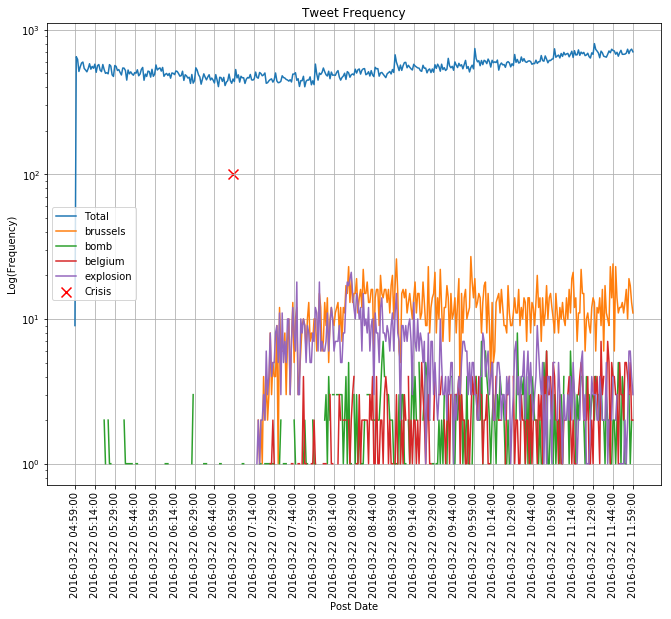

In [15]:
# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)

# Set title
plt.title("Tweet Frequency")

# ticks interval
smallerXTicks = range(0, len(sortedTimes), 15)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot in log-scale because overall tweet volume is much higher than relevant volume
ax.semilogy(range(len(frequencyMap)), totalCount, label="Total")

# Plot a simple X where the disaster occurred
ax.scatter([crisisXCoord], [100], c="r", marker="x", s=100, label="Crisis")

# For each keyword in our target keywords...
for keyword in targetKeywords:
    
    # Print the target count for each keyword and time
    ax.semilogy(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
    
# Legend and titles
ax.set_xlabel("Post Date")
ax.set_ylabel("Log(Frequency)")
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

## Zooming in on textually relevant tweets

We've looked at tweets that happened right after the event, now let's look at tweets that mention the event.

In [16]:
relevant_keyword_tweets = {}

for rel_keyword in targetKeywords:
    relevant_tweets = [tweet 
                       for this_time in 
                           filter(lambda x: x >= crisisTime, sortedTimes) 
                       for tweet in 
                           filter(lambda y: rel_keyword in y["text"].lower(), 
                                  frequencyMap[this_time])
                      ]
    
    relevant_keyword_tweets[rel_keyword] = relevant_tweets
    print("Keyword:", rel_keyword, "Count:", len(relevant_tweets))

Keyword: brussels Count: 3335
Keyword: bomb Count: 539
Keyword: belgium Count: 531
Keyword: explosion Count: 1572


In [17]:
for target_keyword, textually_relevant_tweets in relevant_keyword_tweets.items():

    print("\n------------------------")
    print("Keyword:", target_keyword, "Count:", len(textually_relevant_tweets))

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the hashtags list
    htags = [
            hashtag["text"].lower() 
             for tweet in textually_relevant_tweets 
                 for hashtag in tweet["entities"]["hashtags"]
            ]

    print("Total Hashtag Count:", len(htags))
    print("Unique Hashtag Count:", len(set(htags)))

    htags_freq = nltk.FreqDist(htags)

    print("\nFrequent Hashtags:")
    for tag, count in htags_freq.most_common(20):
        print(tag, count)

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the author list
    authors = [tweet["user"]["screen_name"].lower() for tweet in textually_relevant_tweets]

    print("\nTotal Author Count:", len(authors))
    print("Unique Author Count:", len(set(authors)))

    author_freq = nltk.FreqDist(authors)

    print("\nActive Users:")
    for author, count in author_freq.most_common(20):
        print(author, count)

    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the URL list
    urls = [
            url["expanded_url"]
             for tweet in textually_relevant_tweets 
                 for url in tweet["entities"]["urls"]
            ]

    print("\nTotal URL Count:", len(urls))
    print("Unique URL Count:", len(set(urls)))

    urls_freq = nltk.FreqDist(urls)

    print("\nCommon URLs:")
    for url, count in urls_freq.most_common(20):
        print(url, count)


------------------------
Keyword: brussels Count: 3335
Total Hashtag Count: 3394
Unique Hashtag Count: 478

Frequent Hashtags:
brussels 1544
zaventem 180
brusselsattack 178
brusselsairport 143
prayforbrussels 134
breaking 109
bruxelles 91
belgium 69
maalbeek 39
maelbeek 29
brusselsattacks 21
prayforbelgium 18
vrtnieuws 16
brussel 14
breakingnews 12
brüssel 12
news 11
bruselas 11
belgique 10
brüksel 10

Total Author Count: 3335
Unique Author Count: 3286

Active Users:
kyleraccio 3
mardanone 3
cicjdnsw 3
guidofaux 2
marc2525 2
leandroj1977 2
fidasyahadah 2
kanalukraine_en 2
jackhutton 2
jotdownspain 2
deep__sojitra 2
fd_news 2
israel_flash 2
nonvitaltooth 2
elpananacho 2
ducksquawk 2
plagiat_buruk 2
france24 2
daniele_pezzano 2
playplipala 2

Total URL Count: 1233
Unique URL Count: 824

Common URLs:
http://bbc.in/21ENlj8 33
http://cnn.it/1VyrwSH 23
http://on.rt.com/77nr 22
http://wp.me/p5bZm6-5s6 17
http://on.rt.com/77nz 14
http://bbc.in/1PolAnG 14
http://www.bbc.co.uk/news/world-europe

### Merging All Relevant Tweets

We looked at tweets that match our relevant keywords. Now let's merge them all together.

In [18]:
all_rel_tweets = {tweet["id"]:tweet 
                  for local_tweet_list in relevant_keyword_tweets.values() 
                  for tweet in local_tweet_list}

print("Unique textually relevant tweets:", len(all_rel_tweets))

Unique textually relevant tweets: 4687


In [19]:
textually_relevant_tweets = list(all_rel_tweets.values())

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it tokenizes the tweet text
tokens = [
        token.lower() 
         for tweet in textually_relevant_tweets 
             for token in tokenizer.tokenize(tweet["text"])
        ]
tokens = list(filter(lambda x: x not in stops and len(x) > 3, tokens))

print("Total Token Count:", len(tokens))
print("Unique Token Count:", len(set(tokens)))

tokens_freq = nltk.FreqDist(tokens)

print("\nFrequent Tokens:")
for token, count in tokens_freq.most_common(20):
    print(token, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the hashtags list
htags = [
        hashtag["text"].lower() 
         for tweet in textually_relevant_tweets 
             for hashtag in tweet["entities"]["hashtags"]
        ]

print("\nTotal Hashtag Count:", len(htags))
print("Unique Hashtag Count:", len(set(htags)))

htags_freq = nltk.FreqDist(htags)

print("\nFrequent Hashtags:")
for tag, count in htags_freq.most_common(20):
    print(tag, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the author list
authors = [tweet["user"]["screen_name"].lower() for tweet in textually_relevant_tweets]

print("\nTotal Author Count:", len(authors))
print("Unique Author Count:", len(set(authors)))

author_freq = nltk.FreqDist(authors)

print("\nActive Users:")
for author, count in author_freq.most_common(20):
    print(author, count)

# This list comprehension iterates through the tweet_list list, and for each
#  tweet, it iterates through the URL list
urls = [
        url["expanded_url"]
         for tweet in textually_relevant_tweets 
             for url in tweet["entities"]["urls"]
        ]

print("\nTotal URL Count:", len(urls))
print("Unique URL Count:", len(set(urls)))

urls_freq = nltk.FreqDist(urls)

print("\nCommon URLs:")
for url, count in urls_freq.most_common(20):
    print(url, count)

Total Token Count: 44332
Unique Token Count: 12666

Frequent Tokens:
#brussels 1538
brussels 1403
airport 1155
explosions 854
metro 525
explosion 414
people 303
attacks 297
station 279
belgium 264
explosiones 244
#zaventem 241
#bruxelles 230
dead 225
belgian 219
news 218
breaking 203
attack 200
bruselas 198
injured 184

Total Hashtag Count: 4276
Unique Hashtag Count: 714

Frequent Hashtags:
brussels 1558
zaventem 245
bruxelles 242
brusselsattack 178
brusselsairport 143
prayforbrussels 134
prayforbelgium 125
belgium 112
breaking 109
bruselas 49
maalbeek 44
maelbeek 42
belgique 25
brüssel 21
brusselsattacks 21
brussel 17
vrtnieuws 16
schuman 14
brüksel 13
últimahora 13

Total Author Count: 4687
Unique Author Count: 4622

Active Users:
cicjdnsw 4
kyleraccio 3
mardanone 3
nonvitaltooth 3
kkf_fabricek 3
admcanarisfanpl 3
guidofaux 2
marc2525 2
leandroj1977 2
fidasyahadah 2
kanalukraine_en 2
jackhutton 2
jotdownspain 2
deep__sojitra 2
fd_news 2
israel_flash 2
elpananacho 2
ducksquawk 2
mgq50

Looking at these hashtags, URLs, and users, are there any new tokens we should add to our list of relevant keywords? If so, maybe add them to the crisis map we started above and re-run this notebook.

## Saving Relevant Tweets

For our convenience, we'll go ahead and save these tweets' JSON versions into a separate file, so we don't have to re-read them every time we do want to analysis our data.

In [ ]:
with open("relevant_tweet_output.json", "w") as out_file:
    for tweet in textually_relevant_tweets:
        out_file.write("%s\n" % json.dumps(tweet))